In [315]:
%matplotlib inline

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import urllib2
import requests
from bs4 import BeautifulSoup

In [316]:
#from pandas_datareader import data as pdr
#import fix_yahoo_finance as yf
#yf.pdr_override()
#data = pdr.get_data_yahoo('SPY', start='2017-01-01', ends='2017-12-31')
#print data
#stockList = pd.read_csv('../companylist.csv')
#print stockList['Symbol']'''

In [317]:
stocks = []
stocks.append([])
stocks.append([])
import glob
path = "./stocks/*.csv"
for fname in glob.glob(path):
    stocks[1].append(pd.read_csv(fname))
    stocks[0].append(fname)
print stocks[0][0]
print stocks[1][0]

./stocks/AABA.csv
           Date       Open       High        Low      Close  Adj Close  \
0    2017-01-03  39.110001  39.180000  38.639999  38.900002  38.900002   
1    2017-01-04  39.000000  40.250000  38.919998  40.060001  40.060001   
2    2017-01-05  40.310001  41.369999  40.240002  41.340000  41.340000   
3    2017-01-06  41.250000  41.340000  40.849998  41.230000  41.230000   
4    2017-01-09  41.169998  41.660000  41.130001  41.340000  41.340000   
5    2017-01-10  41.889999  42.369999  41.540001  42.299999  42.299999   
6    2017-01-11  42.270000  42.590000  42.070000  42.590000  42.590000   
7    2017-01-12  42.340000  42.459999  41.700001  42.110001  42.110001   
8    2017-01-13  42.110001  42.459999  42.020000  42.270000  42.270000   
9    2017-01-17  42.060001  42.180000  41.840000  41.990002  41.990002   
10   2017-01-18  42.150002  42.150002  41.799999  42.029999  42.029999   
11   2017-01-19  42.049999  42.189999  41.900002  42.090000  42.090000   
12   2017-01-20  42.

In [318]:
def plotStocks(df, title="Stock prices"):
    ax = df.plot(title=title, fontsize=12)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    plt.show

In [319]:
def get_bollinger_bands(df, window, num_std):
    rolling_mean = df["Close"].rolling(window=window).mean()
    rolling_std = df["Close"].rolling(window=window).std()
    
    upper_band = rolling_mean + num_std * rolling_std
    lower_band = rolling_mean - num_std * rolling_std
    return rolling_mean, upper_band, lower_band

In [320]:
def plot_bollinger_bands(RM, UB, LB, Stock):
    ax = Stock.plot(title="Bollinger Band", label = Stock.name, figsize=(20, 10))
    RM.plot(label='Rolling Mean', ax=ax)
    UB.plot(label='Bollinger Upper Band', ax=ax)
    LB.plot(label='Bollinger Lower Band', ax=ax)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.legend(loc='upper left')
    plt.show()

In [321]:
def get_ATR(df, ATRDays):
    df2 = df
    #df2.reset_index(level=0, inplace=True)
    #df2.reset_index(inplace=True)
    i = 1
    
    TR_1 = [df2.at[0, 'High'] - df2.at[0, 'Low']]
    
    while i< (len(df2.index)):
        hl = abs(df2.at[i-1, 'High'] - df2.at[i-1, 'Low'])
        hCp = abs(df2.at[i-1, 'High'] - df2.at[i, 'Close'])
        lCp = abs(df2.at[i-1, 'Low'] - df2.at[i, 'Close'])
        TR = max(hl, hCp, lCp)
        TR_1.append(TR)
        i = i+1

    TR_s = pd.Series(TR_1)
    i = ATRDays
    ATRarray = [TR_s[:i].mean()]

    while i< (len(TR_s)):
        ATRarray.append((ATRarray[i-ATRDays-1]*(ATRDays-1) + TR_1[i])/ATRDays)
        i=i+1
    ATR = pd.Series(ATRarray, name = "ATR")
    return ATR

In [322]:
def get_keltner_channel(df, ATRDays, EMADays, multiplier):
    ATR = get_ATR(df, ATRDays)
    ATR_s = pd.Series(np.zeros(ATRDays-1))
    ATR = pd.concat([ATR_s, ATR], ignore_index=True)
    
    SMA = (df['High'] + df['Low'] + df['Close'])/3
        
    EMA = pd.Series(SMA.ewm(span = EMADays, min_periods = EMADays).mean(), name='EMA')
    KCU = pd.Series(SMA.ewm(span = EMADays, min_periods = EMADays).mean(), name='KCU')
    KCL = pd.Series(SMA.ewm(span = EMADays, min_periods = EMADays).mean(), name='KCL')
    
    KCU = KCU + (multiplier * ATR)
    KCL = KCL - (multiplier * ATR)
    
    return EMA, KCU, KCL
    

In [323]:
def plot_keltner_channel(EMA, KCU, KCL, Stock):
    ax = Stock.plot(title="Keltner Channel", label = Stock.name, figsize=(20, 10))
    EMA.plot(label='Exponential Moving Average', ax=ax)
    KCU.plot(label='Keltner Upper Channel', ax=ax)
    KCL.plot(label='Keltner Lower Channel', ax=ax)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.legend(loc='upper left')
    plt.show()

In [324]:
def get_moving_average_envelope(df, days, percent):
    SMA = pd.Series(df['Close'].rolling(window=days).mean())
    USMA = SMA + (SMA * percent)
    LSMA = SMA - (SMA * percent)
    
    return SMA, USMA, LSMA

In [325]:
def plot_MAE(SMA, USMA, LSMA, Stock):
    ax = Stock.plot(title="Moving Average Envelope", label = Stock.name, figsize=(20, 10))
    EMA.plot(label='Simple Moving Average', ax=ax)
    USMA.plot(label='Envelope Upper Channel', ax=ax)
    LSMA.plot(label='Envelope Lower Channel', ax=ax)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.legend(loc='upper left')
    plt.show()

In [352]:
# define the first rising sar and falling sar
#check for the trend, deside rising or falling
def get_Parabolic_SAR(df):
    #exam_data01 = {'Date': apple_stock['Date'],'High': apple_stock['High'], 'Low': apple_stock['Low'], 
    #              'Close': apple_stock['Close']}
    #df = pd.DataFrame(exam_data01)
    rising_sar = []
    falling_sar = []
    # index 0 is the date, index 1 is the value
    rising_sar.append([])
    rising_sar.append([])
    falling_sar.append([])
    falling_sar.append([])
    # 1 mean start with rising sar, 0 means start with falling sar
    sar = []
    #deside whether start with falling sar or start with rising sar
    if(df['Close'][1] > df['Close'][0]):
        sar.append(1)
    else:
        sar.append(0)
    
    r_extreme_point = []
    f_extreme_point = []
    r_af = 0.02
    f_af = 0.02

    PSARMoney = 10000
    SellAmount = 1000
    BuyAmount = 1000
    numStocks = PSARMoney/df['Close'][0]
    PSARMoney = 0
    #final_sar = []
    #go through data row by row
    for index, row in df.iterrows():
        #if this is the first stock price, follow the sar we descide before
        #if not, compre the price and descide it is a falling or a rising
        if(index == 0):
            if(sar[0] == 1):
                rising_sar[0].append(row['Date'])
                rising_sar[1].append(row['Low'])
                r_extreme_point.append(row['High'])
            else:
                falling_sar[0].append(row['Date'])
                falling_sar[1].append(row['High'])
                f_extreme_point.append(row['Low'])
        else:
            #if the close price is higher than falling sar, change to rising sar
            #if the close price is lower than rising sar, change to falling sar
            #calculate both extreme point every day
        
            #prior_r_sar = rising_sar[1][len(rising_sar[1])-1]
            #prior_f_sar = falling_sar[1][len(falling_sar[1])-1]
            #prior_r_ep = r_extreme_point[len(r_extreme_point)-1]
            #prior_f_ep = f_extreme_point[len(f_extreme_point)-1]
        
            if(sar[index-1] == 1):
            
                if(row['Close'] < rising_sar[1][len(rising_sar[1])-1]):
                    #now changing to downward trend, falling sar
                
                    if((numStocks-SellAmount/row['Close'])>0):
                        numStocks = numStocks - SellAmount/row['Close']
                        PSARMoney = PSARMoney + SellAmount
                    elif(numStocks>0):
                        PSARMoney = PSARMoney + numStocks*row['Close']
                        numStocks = 0
                
                    r_sar = 0.02
                    try:
                        f_extreme_point.append(row['Low'])
                        sar.append(0)
                        falling_sar[0].append(row['Date'])
                        #falling_sar[1].append((falling_sar[1][len(falling_sar[1])-1] - f_af * 
                        #                      (falling_sar[1][len(falling_sar[1])-1] - f_extreme_point[len(f_extreme_point)-1])))
                        falling_sar[1].append(row['High'])
                        if(row['Low'] < f_extreme_point[len(f_extreme_point)-1]):
                            f_extreme_point.append(row['Low'])
                            if(f_af < 0.2):
                                f_af += 0.02
                    except:
                        #falling_sar[0].append(row['Date'])
                        falling_sar[1].append(row['High'])
                        f_extreme_point.append(row['Low'])
                else:
                    # continue upward trend, rising sar
                    sar.append(1)
                    rising_sar[0].append(row['Date'])
                    rising_sar[1].append((rising_sar[1][len(rising_sar[1])-1] + r_af * 
                                          (r_extreme_point[len(r_extreme_point)-1] - rising_sar[1][len(rising_sar[1])-1])))
                
                    if(row['High'] > r_extreme_point[len(r_extreme_point)-1]):
                        r_extreme_point.append(row['High'])
                        if(r_af < 0.2):
                            r_af += 0.02
            else:
                if(row['Close'] > falling_sar[1][len(falling_sar[1])-1]):
                    #change to upward trend
                
                    numStocks = numStocks + BuyAmount/row['Close']
                    PSARMoney = PSARMoney - BuyAmount
                
                    f_sar = 0.02
                    try:
                        r_extreme_point.append(row['High'])
                        sar.append(1)
                        rising_sar[0].append(row['Date'])
                        #rising_sar[1].append((rising_sar[1][len(rising_sar[1])-1] + r_af * 
                         #                     (r_extreme_point[len(r_extreme_point)-1] - rising_sar[1][len(rising_sar[1])-1])))
                        rising_sar[1].append(row['Low'])
                        if(row['High'] >= r_extreme_point[len(r_extreme_point)-1]):
                            r_extreme_point.append(row['High'])
                            if(r_af < 0.2):
                                r_af += 0.02
                    except:
                        #rising_sar[0].append(row['Date'])
                        rising_sar[1].append(row['Low'])
                        r_extreme_point.append(row['High'])
                else:
                    #continue with downward trend
                    sar.append(0)
                    falling_sar[0].append(row['Date'])
                    falling_sar[1].append((falling_sar[1][len(falling_sar[1])-1] - f_af * 
                                           (falling_sar[1][len(falling_sar[1])-1] - f_extreme_point[len(f_extreme_point)-1])))
                    if(row['Low'] <= f_extreme_point[len(f_extreme_point)-1]):
                        f_extreme_point.append(row['Low'])
                        if(f_af < 0.2):
                            f_af += 0.02
    PSARMoney = PSARMoney + numStocks*df['Close'].iloc[-1]
    return PSARMoney

In [353]:
#df = pd.read_csv('../../dataset/AAPL-weekly.csv')
# Draw the close only plot 
def createUpperChannel(close_price, index):
    # choose the highest close price within index-days
    # ex: index = 2, from date No.3
    upper_channel = []
    # include index, exclude len(df['Close'])
    for a in range(index, len(close_price)):
        current_max = close_price[a-index]
        # 1, 2, 3, 4, 5
        for b in range((a - index), a):
            if (close_price[b] > current_max):
                current_max = close_price[b]
        upper_channel.append(current_max)
    return upper_channel

def createLowerChannel(close_price, index):
    lower_channel = []
    # include index, exclude len(df['Close'])
    for a in range(index, len(close_price)):
        current_min = close_price[a-index]
        # 1, 2, 3, 4, 5
        for b in range((a - index), a):
            if (close_price[b] < current_min):
                current_min = close_price[b]
        lower_channel.append(current_min)
    return lower_channel

def createMiddleChannel(upper, lower):
    middle_channel = []
    # include index, exclude len(df['Close'])
    for a in range(0, len(upper)):
        middle_channel.append((upper[a]+lower[a])/2)
    return middle_channel

def createCurrentPrice(close_price, index):
    current_price = []
    for a in range(index, len(close_price)):
        current_price.append(close_price[a])
    return current_price

def createDate(close_price, index):
    date = []
    for a in range(index, len(close_price)):
        date.append(close_price[a])
    return date

#upper = createUpperChannel(df.Close, 20)
#lower = createLowerChannel(df.Close, 20)
#middle = createMiddleChannel(upper, lower)
#current = createCurrentPrice(df.Close, 20)
#date = createDate(df.Date, 20)

#info = {'Date':date, 'Upper':upper, 'Middle':middle,
        #'Lower':lower, 'Current':current}
#channel_data = pd.DataFrame(info)
#channel_data.Date = pd.to_datetime(channel_data.Date)


In [354]:
#version 1
def get_Money_Price_Channel(channel_data):
    cash = 10000
    step_amount = 1000
    volume = 0
    current_price = channel_data.Current[0]

    #buy $10000 stock at the begining
    volume += int(10000 / current_price)
    cash = 10000 - volume * current_price

    for a in range(0,len(upper)):
        current_price = channel_data.Current[a]
        if current_price > channel_data.Upper[a]:
            #buy stocks use $1000, the step amount
            num_to_sell = int(step_amount / current_price)
            if(volume < num_to_sell):
                volume = 0
                cash += volume * current_price
            else:
                volume = volume - num_to_sell
                cash += num_to_sell * current_price
        # if the price lower than the lower channel, I need to sell stock
        elif current_price < channel_data.Lower[a]:
            volume = volume + int(step_amount/current_price)
        
    # The final amount of money I can get is to sell all my stock at the last day + my cash remained
    balance = volume * channel_data.Current[len(channel_data.Current)-1] + cash
    return balance

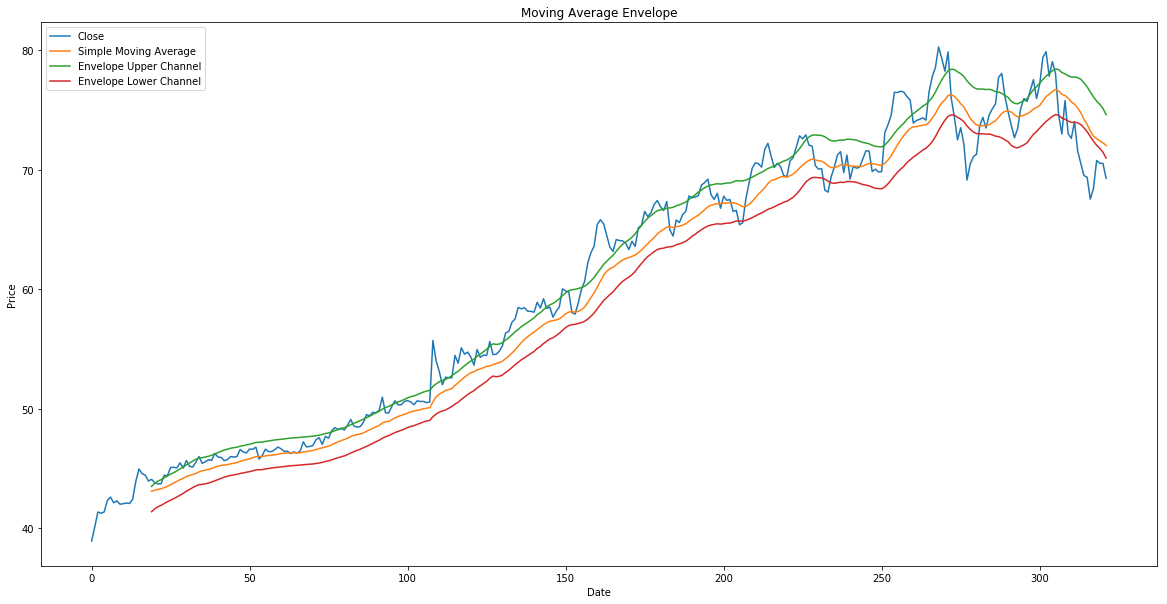

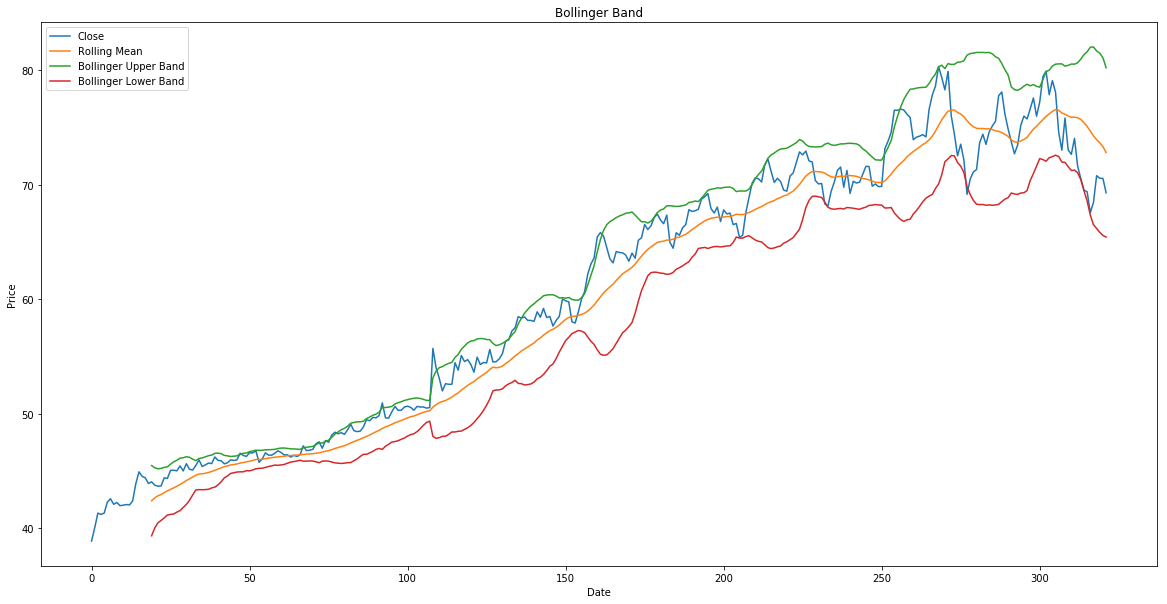

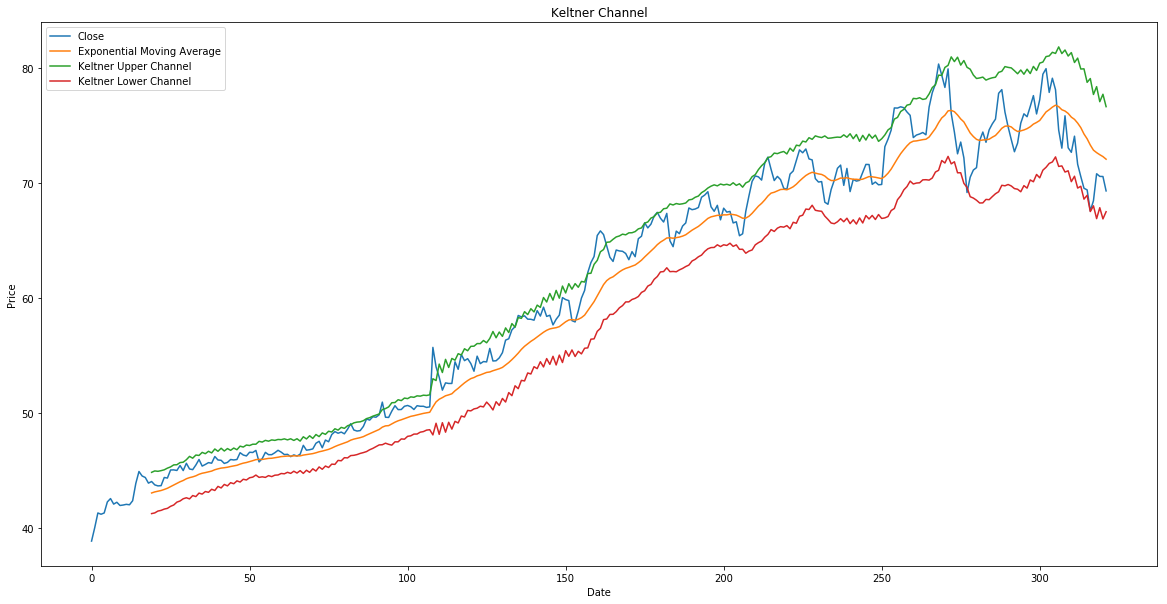

In [355]:
ATRDays = 10
EMADays = 20
multiplier = 2
window = 20
num_std = 2


RM, UBB, LBB, = get_bollinger_bands(df, window, num_std)

EMA, KCU, KCL = get_keltner_channel(df, ATRDays, EMADays, multiplier)

SMA, USMA, LSMA = get_moving_average_envelope(df, window, .025)
plot_MAE(SMA, USMA, LSMA, df['Close'])
#print UBB.tail()
#print LBB.tail()

plot_bollinger_bands(RM, UBB, LBB, df['Close'])
plot_keltner_channel(EMA, KCU, KCL, df['Close'])

In [356]:
def computeMoney(money, StockSold, StockBuy, Stock, UB, LB):
    days = Stock.count()-UB.count()
    numStocks = money/Stock[0]
    money = 0
    for i in range(UB.count()):
        #print Stock[i+days-1]
        if(Stock[i+days]<=UB[i+days] and i != 0 and Stock[i+days-1]>=UB[i+days-1]):
            if(numStocks-StockSold/Stock[i+days]>0):
                numStocks = numStocks - StockSold/Stock[i+days]
                money = money + StockSold
                #print Stock.index[i+days]
                #print numStocks
                #print money
            elif(numStocks>0):
                money = money + numStocks*Stock.iloc[i+days]
                numStocks = 0
                #print Stock.index[i+days]
                #print numStocks
                #print money
            
        if(Stock[i+days]>=LB[i+days] and i != 0 and Stock[i+days-1]<=LB[i+days-1]):
            numStocks = numStocks + StockBuy/Stock[i+days]
            money = money - StockBuy
            #print Stock.index[i+days]
            #print numStocks
            #print money
    money = money + numStocks*Stock.iloc[-1]
            
    return money

In [357]:
#BBmoney = 10000
#df = stocks[1][0]
#print stocks[1][0:100]
#SMAmoney = computeMoney(BBmoney, 1000, 1000, df['Close'], USMA, LSMA)
#BBnewMoney = computeMoney(BBmoney, 1000, 1000, df['Close'], UBB, LBB)
#KCMoney = computeMoney(BBmoney, 1000, 1000, df['Close'], KCU, KCL)
#print SMAmoney
#print BBnewMoney
#print KCMoney

In [358]:
endMoneyBB = []
endMoneyBB.append([])
endMoneyBB.append([])

endMoneyKC = []
endMoneyKC.append([])
endMoneyKC.append([])

endMoneyME = []
endMoneyME.append([])
endMoneyME.append([])

endMoneyPSAR = []
endMoneyPSAR.append([])
endMoneyPSAR.append([])

endMoneyPC = []
endMoneyPC.append([])
endMoneyPC.append([])

endMoneyDif = []
for i in range(50):
#for i in range(100):
    beginMoney = 10000
    amountSold = 1000
    amountBought = 1000
    RM, UBB, LBB, = get_bollinger_bands(stocks[1][i], window, num_std)

    EMA, KCU, KCL = get_keltner_channel(stocks[1][i], ATRDays, EMADays, multiplier)
    
    SMA, USMA, LSMA = get_moving_average_envelope(stocks[1][i], window, .025)
    
    
    
    upper = createUpperChannel(stocks[1][i].Close, 20)
    lower = createLowerChannel(stocks[1][i].Close, 20)
    middle = createMiddleChannel(upper, lower)
    current = createCurrentPrice(stocks[1][i].Close, 20)
    date = createDate(stocks[1][i].Date, 20)

    info = {'Date':date, 'Upper':upper, 'Middle':middle,
            'Lower':lower, 'Current':current}
    channel_data = pd.DataFrame(info)
    channel_data.Date = pd.to_datetime(channel_data.Date)
    
    
    endMoneyBB[0].append(stocks[0][i])
    endMoneyBB[1].append(computeMoney(beginMoney, amountSold, amountBought, stocks[1][i]['Close'], UBB, LBB))
    
    endMoneyKC[0].append(stocks[0][i])
    endMoneyKC[1].append(computeMoney(beginMoney, amountSold, amountBought, stocks[1][i]['Close'], KCU, KCL))
    
    endMoneyME[0].append(stocks[0][i])
    endMoneyME[1].append(computeMoney(beginMoney, amountSold, amountBought, stocks[1][i]['Close'], USMA, LSMA))
    
    endMoneyPC[0].append(stocks[0][i])
    endMoneyPC[1].append(get_Money_Price_Channel(channel_data))
    
    endMoneyPSAR[0].append(stocks[0][i])
    endMoneyPSAR[1].append(get_Parabolic_SAR(stocks[1][i]))
    
    endMoneyDif.append(np.max([endMoneyBB[1][i], endMoneyKC[1][i], endMoneyME[1][i], endMoneyPC[1][i], endMoneyPSAR[1][i]]))
print endMoneyDif

[21366.490423000003, 43740.880210999996, 25425.799999999996, 53630.150909000004, 39738.349618, 26310.339794, 39324.050284000004, 21253.759815999998, 36574.230698000007, 44547.099999999999, 39122.120298999995, 36279.950171000004, 41845.840000000004, 50459.320000000007, 45312.046545382036, 304950.34199999995, 21720.419999999998, 25398.81585286673, 25539.40430064352, 41164.100027999993, 32975.300000000003, 49537.77937299999, 27725.875521999998, 77468.03394899999, 37975.739344999995, 18947.869999999999, 35174.279551, 22801.630278000001, 29734.169871999999, 38334.529308999998, 51373.860000000001, 39440.569709999996, 48001.719251999995, 49755.259999999995, 35755.679646999997, 34918.049353000002, 23668.014999999999, 37649.800137999999, 40485.279555000001, 53321.731283999994, 36442.169999999998, 38441.775000000001, 34363.880000000005, 17847.302415999999, 43217.629999999997, 18423.990386000001, 18765.820198000001, 33805.919720999998, 82936.194999999992, 21273.461751388324]


In [361]:
average = np.mean(endMoneyDif)
print np.max([endMoneyBB[1], endMoneyKC[1], endMoneyME[1]])
average2 = np.mean(endMoneyKC[1])
average3 = np.mean(endMoneyBB[1])
average4 = np.mean(endMoneyME[1])
print average
print average2
print average3
print average4
bestOver = pd.DataFrame()
bestOver['Stock'] = stocks[0][0:50]
bestOver['Best Overlay Price'] = endMoneyDif
bestOverlay = []
for i in range(len(endMoneyDif)):
    if(endMoneyDif[i] == endMoneyBB[1][i]):
        bestOverlay.append("Bollinger Band")
    elif(endMoneyDif[i] == endMoneyKC[1][i]):
        bestOverlay.append("Keltner Channel")
    elif(endMoneyDif[i] == endMoneyME[1][i]):
        bestOverlay.append("Moving Envelope")
    elif(endMoneyDif[i] == endMoneyPC[1][i]):
        bestOverlay.append("Price Channel")
    elif(endMoneyDif[i] == endMoneyPSAR[1][i]):
        bestOverlay.append("Parabolic SAR")
    else:
        bestOverlay.append("Error")
bestOver["Best Overlay"] = bestOverlay
print bestOver

45312.0465454
42285.3365312
12600.5603829
12982.9788479
12960.9270094
                 Stock  Best Overlay Price     Best Overlay
0    ./stocks/AABA.csv        21366.490423    Price Channel
1     ./stocks/AAL.csv        43740.880211    Price Channel
2    ./stocks/AAME.csv        25425.800000    Price Channel
3    ./stocks/AAOI.csv        53630.150909    Price Channel
4    ./stocks/AAON.csv        39738.349618    Price Channel
5    ./stocks/AAPL.csv        26310.339794    Price Channel
6    ./stocks/AAWW.csv        39324.050284    Price Channel
7    ./stocks/AAXJ.csv        21253.759816    Price Channel
8    ./stocks/AAXN.csv        36574.230698    Price Channel
9    ./stocks/ABAC.csv        44547.100000    Price Channel
10   ./stocks/ABAX.csv        39122.120299    Price Channel
11   ./stocks/ABCB.csv        36279.950171    Price Channel
12   ./stocks/ABCD.csv        41845.840000    Price Channel
13   ./stocks/ABDC.csv        50459.320000    Price Channel
14   ./stocks/ABEO.csv        